In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
!ls /kaggle/input/chest-xray-pneumonia


chest_xray


In [ ]:
!ls /kaggle/input/chest-xray-pneumonia/chest_xray

chest_xray  __MACOSX  test  train  val


In [ ]:
data_dir = "chest_xray"

In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

In [ ]:
print("Torch version:", torch.__version__)

Torch version: 2.9.0+cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "val"),
    transform=val_test_transforms
)

test_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "test"),
    transform=val_test_transforms
)

print("Classes:", train_dataset.classes)
print("Training samples:", len(train_dataset))


Classes: ['NORMAL', 'PNEUMONIA']
Training samples: 5216


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
def train_model(model, train_loader, epochs=2):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
train_model(model, train_loader, epochs=2)

Epoch 1/2, Loss: 0.1401
Epoch 2/2, Loss: 0.1426


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
val_data   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform)
test_data  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Datasets loaded:")
print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))


Datasets loaded:
Train: 5216
Val: 16
Test: 624


In [ ]:
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Accuracy:", accuracy)
print("AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Confusion Matrix:\n", cm)


Accuracy: 0.625
AUC: 0.4461154941924173
Sensitivity: 1.0
Specificity: 0.0
Confusion Matrix:
 [[  0 234]
 [  0 390]]


In [ ]:
# Install dependencies if needed
!pip install torch torchvision --quiet
!pip install sklearn --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

print("Torch version:", torch.__version__)


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Torch version: 2.9.0+cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
val_data   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform)
test_data  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Train samples:", len(train_data))
print("Val samples:", len(val_data))
print("Test samples:", len(test_data))


Train samples: 5216
Val samples: 16
Test samples: 624


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [29]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")


In [30]:
train_model(model, train_loader, val_loader, epochs=5)


Epoch 1/5, Loss: 0.1312, Val Acc: 0.8125
Epoch 2/5, Loss: 0.1151, Val Acc: 0.7500
Epoch 3/5, Loss: 0.1210, Val Acc: 0.8750
Epoch 4/5, Loss: 0.1136, Val Acc: 0.7500
Epoch 5/5, Loss: 0.1081, Val Acc: 0.7500


In [31]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Accuracy:", accuracy)
print("AUC:", auc_score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Confusion Matrix:\n", cm)


Accuracy: 0.7836538461538461
AUC: 0.9370644312952006
Sensitivity: 0.9871794871794872
Specificity: 0.4444444444444444
Confusion Matrix:
 [[104 130]
 [  5 385]]


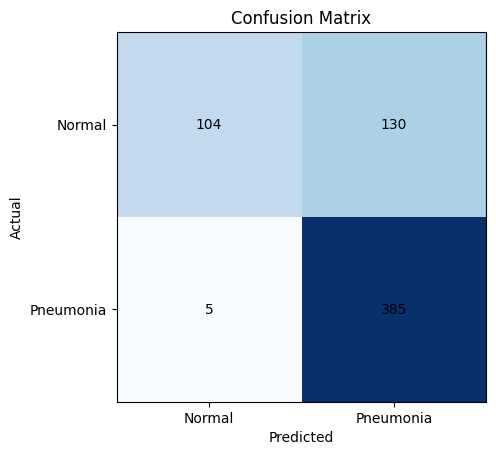

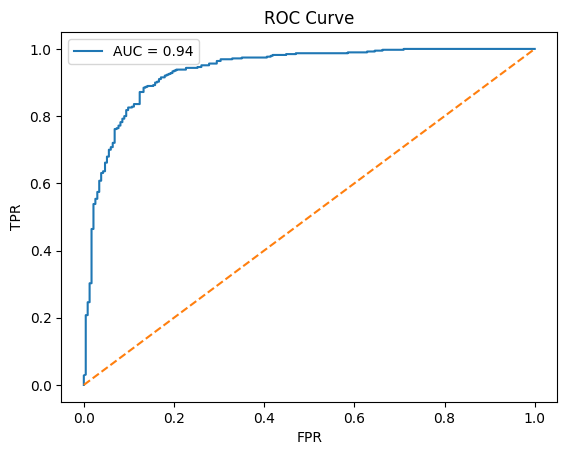

In [32]:
# Confusion Matrix Plot
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Normal","Pneumonia"])
plt.yticks([0,1], ["Normal","Pneumonia"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()
